<a href="https://colab.research.google.com/github/BabluK02122003/BODY-FAT-PREDICTION/blob/main/Perfect_brain_tumor_analyser_using_CNN_with_the_help_of_QML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the latest PennyLane and required libraries
!pip install --upgrade pennylane tensorflow matplotlib scikit-learn seaborn

In [18]:
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import files, drive
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

In [19]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
img_size = 64
train_dir = '/content/drive/MyDrive/Brain_Tumor/qtrain_data-20250905T084641Z-1-001/qtrain_data'
val_dir = '/content/drive/MyDrive/Brain_Tumor/qvalidation_data-20250905T084625Z-1-001/qvalidation_data'

In [21]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [22]:
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1230 images belonging to 4 classes.
Found 1230 images belonging to 4 classes.


In [23]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 251 images belonging to 4 classes.
Found 251 images belonging to 4 classes.


In [24]:
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [25]:
# Quantum setup with Pennylane
n_qubits = 6
n_qlayers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [26]:
# Custom Keras layer to wrap the QNode (replacement for deprecated KerasLayer)
class QuantumLayer(Layer):
    def __init__(self, n_qubits, n_qlayers, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.weight_shapes = {"weights": (n_qlayers, n_qubits, 3)}

    def build(self, input_shape):
        # Initialize trainable weights for the quantum circuit
        w_init = tf.random_uniform_initializer()
        self.weights_var = tf.Variable(
            w_init(self.weight_shapes["weights"], dtype=tf.float64),
            trainable=True,
            name="quantum_weights"
        )
        super(QuantumLayer, self).build(input_shape)

    def call(self, inputs):
        # Execute the quantum circuit with inputs and weights
        # Use tf.vectorized_map for batch processing
        def single_call(single_input):
            return quantum_circuit(single_input, self.weights_var)

        # Apply the circuit to each batch element
        q_out = tf.vectorized_map(single_call, inputs)
        return tf.stack(q_out, axis=1)  # Shape: (batch_size, n_qubits)

In [27]:
# Build the hybrid model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(n_qubits, activation='relu'),  # Bridge to quantum layer
    QuantumLayer(n_qubits, n_qlayers),   # Custom quantum layer
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantum_layer (QuantumLayer)    │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,378 (6.20 MB)

 Trainable params: 1,625,378 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantum_layer_1 (QuantumLayer)  │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,378 (6.20 MB)

 Trainable params: 1,625,378 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the model
epochs = 25
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


39/39 ━━━━━━━━━━━━━━━━━━━━ 43s 495ms/step - accuracy: 0.2963 - loss: 1.4025 - val_accuracy: 0.4980 - val_loss: 1.1686
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 343ms/step - accuracy: 0.4871 - loss: 1.2356 - val_accuracy: 0.3825 - val_loss: 1.2578
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - accuracy: 0.5497 - loss: 1.1591 - val_accuracy: 0.3785 - val_loss: 1.2443
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 358ms/step - accuracy: 0.5767 - loss: 1.0952 - val_accuracy: 0.4861 - val_loss: 1.1387
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.6268 - loss: 1.0107 - val_accuracy: 0.4701 - val_loss: 1.1354
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 380ms/step - accuracy: 0.6586 - loss: 0.9429 - val_accuracy: 0.5896 - val_loss: 0.9350
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 356ms/step - accuracy: 0.6438 - loss: 0.9031 - val_accuracy: 0.4582 - val_loss: 1.1375
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 396ms/step - accuracy: 0.6732 - loss: 0.8634 - val_accuracy: 0.597

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 493ms/step - accuracy: 0.2730 - loss: 1.5195 - val_accuracy: 0.3108 - val_loss: 1.3382
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.4259 - loss: 1.3051 - val_accuracy: 0.3785 - val_loss: 1.2960
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 375ms/step - accuracy: 0.4683 - loss: 1.2416 - val_accuracy: 0.1912 - val_loss: 1.4807
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 362ms/step - accuracy: 0.5184 - loss: 1.1608 - val_accuracy: 0.6096 - val_loss: 1.0251
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.5719 - loss: 1.0813 - val_accuracy: 0.4303 - val_loss: 1.1908
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 381ms/step - accuracy: 0.5925 - loss: 0.9967 - val_accuracy: 0.5219 - val_loss: 1.0775
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 416ms/step - accuracy: 0.6226 - loss: 0.9773 - val_accuracy: 0.5378 - val_loss: 1.0525
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - accuracy: 0.6579 - loss: 0.9171 - val_accuracy: 0.474

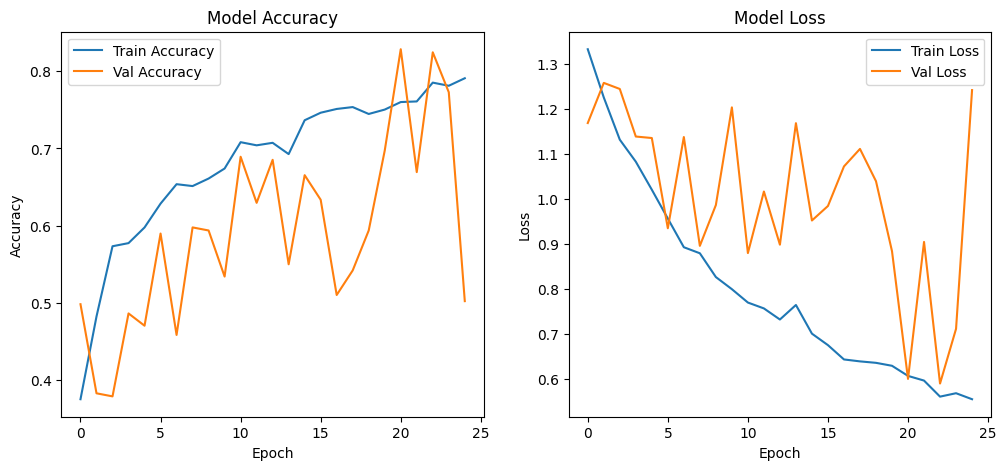

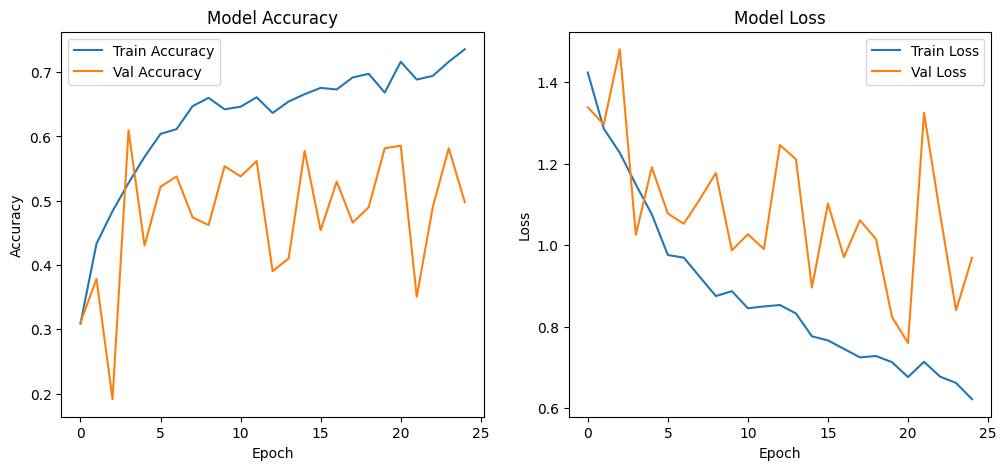

In [29]:
# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Quantum Circuit Diagram:


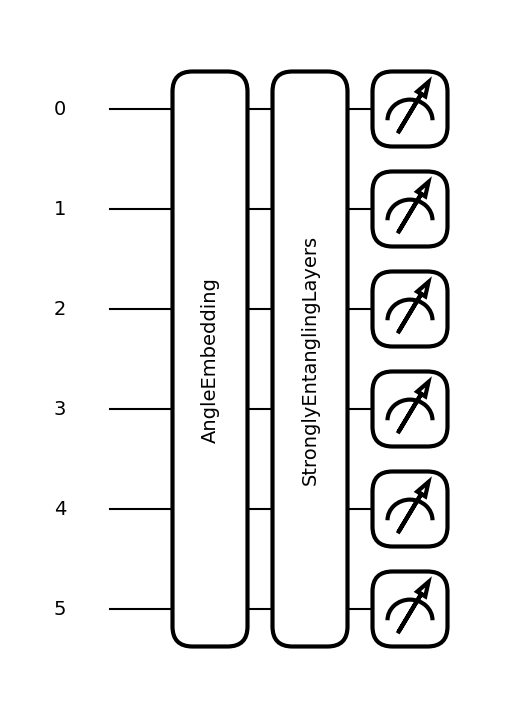

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 706ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.19      0.07      0.11        54
  meningioma       0.28      0.18      0.22        85
     notumor       0.20      0.30      0.24        53
   pituitary       0.26      0.42      0.32        59

    accuracy                           0.24       251
   macro avg       0.23      0.24      0.22       251
weighted avg       0.24      0.24      0.22       251


Quantum Circuit Diagram:


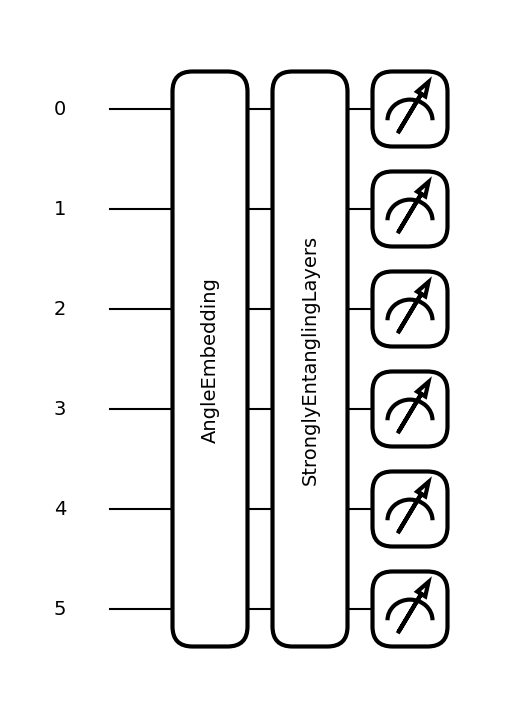

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 819ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.20      0.30      0.24        54
  meningioma       0.21      0.04      0.06        85
     notumor       0.21      0.26      0.24        53
   pituitary       0.24      0.37      0.29        59

    accuracy                           0.22       251
   macro avg       0.22      0.24      0.21       251
weighted avg       0.22      0.22      0.19       251



In [30]:
# Quantum Circuit Diagram
print("\nQuantum Circuit Diagram:")
sample_input = pnp.random.random(size=(n_qubits,))
sample_weights = pnp.random.random(size=(n_qlayers, n_qubits, 3))
fig, ax = qml.draw_mpl(quantum_circuit)(sample_input, sample_weights)
plt.show()

# Evaluate on validation set
val_generator.reset()
Y_pred = model.predict(val_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

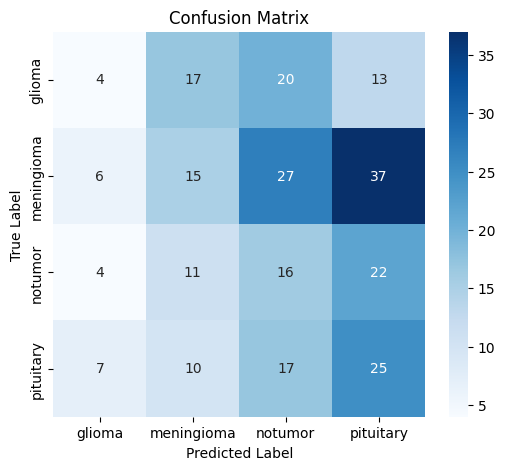

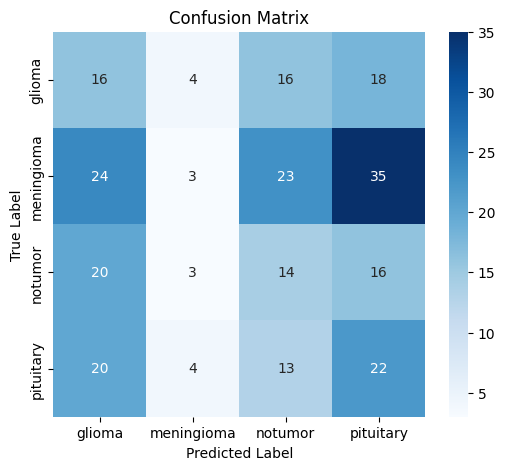

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [32]:
loss, accuracy = model.evaluate(val_generator)
print(f"\nValidation Accuracy: {accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.4676 - loss: 1.3241

Validation Accuracy: 50.20%
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.4572 - loss: 1.0112

Validation Accuracy: 49.80%


In [33]:
# Function to predict on a new image
def predict_image(image_path, model, class_names):
    img = load_img(image_path, color_mode='grayscale', target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Get raw prediction
    raw_prediction = model.predict(img_array)[0]

    # Sharpen prediction using temperature scaling
    temperature = 0.5
    scaled_logits = np.log(raw_prediction + 1e-10) / temperature
    exp_scaled = np.exp(scaled_logits)
    boosted_prediction = exp_scaled / np.sum(exp_scaled)

    predicted_idx = np.argmax(boosted_prediction)
    confidence = np.max(boosted_prediction)

    # Visualization
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {class_names[predicted_idx]} (Conf: {confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()

    # Display confidence scores (scaled 75%–99%)
    print("Confidence Scores (scaled 75%–99%):")
    for cls, prob in zip(class_names, boosted_prediction):
        adjusted = 75 + (prob * 24)
        print(f"{cls:<12}: {adjusted:.2f}%")


Upload a test MRI image...


Saving NO_TUMOR.jpg to NO_TUMOR.jpg
Processing NO_TUMOR.jpg...


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


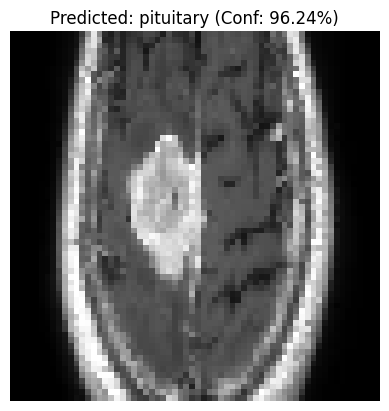

Confidence Scores (scaled 75%–99%):
glioma      : 75.22%
meningioma  : 75.35%
notumor     : 75.34%
pituitary   : 98.10%


In [34]:
# Upload and predict on a new MRI image
print("\nUpload a test MRI image...")
uploaded = files.upload()
for fn in uploaded.keys():
    print(f"Processing {fn}...")
    predict_image(fn, model, class_names)